In this notebook we continue exploring StoreSale dataset but usig a different approach. We will extract all 1782 series using the pivot table to find out more about the behavior of each series.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import statsmodels.api as sm
import plotly.express as px

In [4]:
def create_final_dataframe(main_data):
    #load all aditional dataframes
    oil_data = pd.read_csv("./Data/oil.csv", parse_dates= ["date"])
    holiday_data = pd.read_csv("./Data/holidays_events.csv", parse_dates= ["date"])
    stores_data = pd.read_csv("./Data/stores.csv")
    trans_data = pd.read_csv("./Data/transactions.csv", parse_dates= ['date'])

    # preprocess dataframes: updating datatypes and filling missing values

    main_datatype = {"store_nbr": "category", "family" :"category"}
    main_data = main_data.astype(main_datatype)

    oil_data.fillna(method = "backfill", inplace = True)

    holiday_datatypes = {"type": "category","locale":"category", "locale_name": "category", "description": "string"}
    holiday_data = holiday_data.astype(holiday_datatypes)

    stores_data = stores_data.astype("category")

    # split holiday dataframe based on holiday types
    holiday_local  = holiday_data[holiday_data["locale"]== "Local"].copy()
    holiday_local.rename(columns={'locale_name': 'city'}, inplace=True)
    holiday_local= holiday_local.drop_duplicates(subset=['date', 'city'])
    holiday_regional  = holiday_data[holiday_data["locale"]== "Regional"].copy()
    holiday_regional.rename(columns={'locale_name': 'state'}, inplace=True)
    holiday_regional= holiday_regional.drop_duplicates(subset=['date', 'state'])
    holiday_national = holiday_data[holiday_data["locale"]== "National"].copy()
    holiday_national= holiday_national.drop_duplicates(subset=['date'])

    # merging all frames to create the final dataframe: 
    df = main_data.merge(oil_data, on = "date", how = "left").fillna(method = 'ffill')
    df = df.merge(stores_data, on = "store_nbr", how = "left", )
    df = df.merge(trans_data, on = ["date", "store_nbr"], how = "left")
    df = df.merge(holiday_local, on = ["date", "city"], how = "left", suffixes= ("_store", "_holiday")) 
    df = df.merge(holiday_regional, on = ["date", "state"], how = "left",)
    df = df.merge(holiday_national, on ="date", how = "left")
    
    # Filing missing values of type holiday variable in the df dataframe
    type_holiday = df['type_holiday'].combine_first(df['type_x']).combine_first(df['type_y'])
    locale = df['locale_x'].combine_first(df['locale_y']).combine_first(df['locale'])
    transferred =  df['transferred_x'].combine_first(df['transferred_y']).combine_first(df['transferred'])
    
    # create the final version of df dataframe by adding the correct columns of holiday dataframe
    df = df.iloc[:, :11]
    df['type_holiday']= type_holiday
    df['locale']= locale
    df['transferred'] = transferred

    # trim the final dataframe by improving its columns' datatypes and imputing the missing values
    df['type_holiday'] = df['type_holiday'].cat.add_categories("IsNotHoliday")  
    df['locale'] = df['locale'].cat.add_categories("IsNotHoliday") 

    fill_values = {"type_holiday" :"IsNotHoliday", "locale":"IsNotHoliday"}
    df.fillna(fill_values, inplace = True)

    df.fillna({"transferred": False, "transactions": 0}, inplace = True)

    df = df.astype({"city":"category", "state": "category"})

    return df



In [5]:
train_data = pd.read_csv("./Data/train.csv", parse_dates = ['date'] ,  index_col='id')

df = create_final_dataframe(train_data)

df

C:\Users\solmaz\AppData\Local\Temp\ipykernel_13588\436738443.py:54: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.fillna(fill_values, inplace = True)


,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type_store,cluster,transactions,type_holiday,locale,transferred
0,2013-01-01,1,AUTOMOTIVE,0.000,0,93.14,Quito,Pichincha,D,13,0.0,Holiday,National,False
1,2013-01-01,1,BABY CARE,0.000,0,93.14,Quito,Pichincha,D,13,0.0,Holiday,National,False
2,2013-01-01,1,BEAUTY,0.000,0,93.14,Quito,Pichincha,D,13,0.0,Holiday,National,False
3,2013-01-01,1,BEVERAGES,0.000,0,93.14,Quito,Pichincha,D,13,0.0,Holiday,National,False
4,2013-01-01,1,BOOKS,0.000,0,93.14,Quito,Pichincha,D,13,0.0,Holiday,National,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0,47.57,Quito,Pichincha,B,6,2155.0,IsNotHoliday,IsNotHoliday,False
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,Quito,Pichincha,B,6,2155.0,IsNotHoliday,IsNotHoliday,False
3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,Quito,Pichincha,B,6,2155.0,IsNotHoliday,IsNotHoliday,False
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,Quito,Pichincha,B,6,2155.0,IsNotHoliday,IsNotHoliday,False


In [6]:
df['year'] = df["date"].apply(lambda x: x.year)
df['month'] = df["date"].apply(lambda x: x.month)
df['day'] = df["date"].apply(lambda x : x.day)
df['dayweek'] = df["date"].apply(lambda x : x.day_name())
df["quarter"] = df["date"].apply(lambda x: x.quarter)
df["weekyear"]= df["date"].apply(lambda x: x.weekofyear).astype("category")
df["isweekend"] = df["date"].dt.dayofweek // 5 

# Pivot table based based on `date`, `store_nbr` and `family`

In [8]:
df_sales =pd.pivot_table(df, values ='sales', index = 'date', columns= ['store_nbr', 'family'])
df_sales

store_nbr          1                                                 \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0      0.00000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0    470.65200   
2013-01-03        3.0       0.0    0.0     919.0   0.0    310.65500   
2013-01-04        3.0       0.0    3.0     953.0   0.0    198.36600   
2013-01-05        5.0       0.0    3.0    1160.0   0.0    301.05700   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0    145.60700   
2017-08-12        6.0       0.0    3.0    1659.0   0.0    243.22000   
2017-08-13        1.0       0.0    1.0     803.0   0.0    136.67900   
2017-08-14        1.0       0.0    6.0    2201.0   0.0    346.03800   
2017-08-15        4.0       0.0    4.0    1942.0   0.0    329.54102   

store_nbr                                        ...        54             \
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES      MEATS   
date                                             ...                        
2013-01-01         0.0      0.0    0.0    0.000  ...       0.0   0.000000   
2013-01-02         0.0   1060.0  579.0  164.069  ...       0.0  73.771000   
2013-01-03         0.0    836.0  453.0  151.582  ...       0.0  50.257000   
2013-01-04         0.0    827.0  460.0  131.411  ...       0.0  40.223000   
2013-01-05         0.0    811.0  464.0  118.613  ...       0.0  43.431000   
...                ...      ...    ...      ...  ...       ...        ...   
2017-08-11         4.0    341.0  343.0   64.302  ...       0.0  50.756000   
2017-08-12         3.0    351.0  526.0   99.488  ...       1.0  53.079002   
2017-08-13         1.0    169.0  266.0   47.770  ...       3.0  67.435000   
2017-08-14         4.0    571.0  699.0  154.578  ...       1.0  64.224000   
2017-08-15        21.0    703.0  602.0  116.402  ...       2.0  57.842000   

store_nbr                                                                 \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS    POULTRY   
date                                                                       
2013-01-01           0.0          0.0                     0.0   0.000000   
2013-01-02         228.0          0.0                     0.0  15.514000   
2013-01-03         156.0          0.0                     0.0   4.313000   
2013-01-04         146.0          0.0                     0.0  26.743000   
2013-01-05         205.0          0.0                     0.0  31.118000   
...                  ...          ...                     ...        ...   
2017-08-11         155.0          0.0                     0.0  80.759000   
2017-08-12         169.0          0.0                     4.0  91.671000   
2017-08-13         244.0          0.0                     2.0  79.062996   
2017-08-14         200.0          0.0                     1.0  56.155000   
2017-08-15         169.0          0.0                     2.0  59.619000   

store_nbr                                                              
family     PREPARED FOODS  PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                   
2013-01-01            0.0    0.000                        0.0     0.0  
2013-01-02           61.0    0.000                        0.0     3.0  
2013-01-03            1.0    0.000                        0.0     2.0  
2013-01-04           38.0    0.000                        0.0     2.0  
2013-01-05           32.0    0.000                        0.0     1.0  
...                   ...      ...                        ...     ...  
2017-08-11           54.0  546.250                        0.0     0.0  
2017-08-12           81.0  696.920                        0.0     1.0  
2017-08-13           91.0  877.304                        0.0     2.0

In [11]:
# Assuming df_sales is your pivot table

family = 'BEVERAGES'
store_nbr = 1
selected_data = df_sales.loc[:, (store_nbr, family)]

# Reset index to make 'date' a regular column
selected_data = selected_data.reset_index()

# Rename the selected column
selected_data['sales'] = selected_data[(store_nbr, family)]

# Drop the original multi-level column
selected_data = selected_data.drop(columns=[(store_nbr, family)])

# Plot the data using Plotly Express
fig = px.line(selected_data, x='date', y='sales', title = f"store_nbr ={store_nbr} and family = {family} over time")

# Show the plot
fig.show()


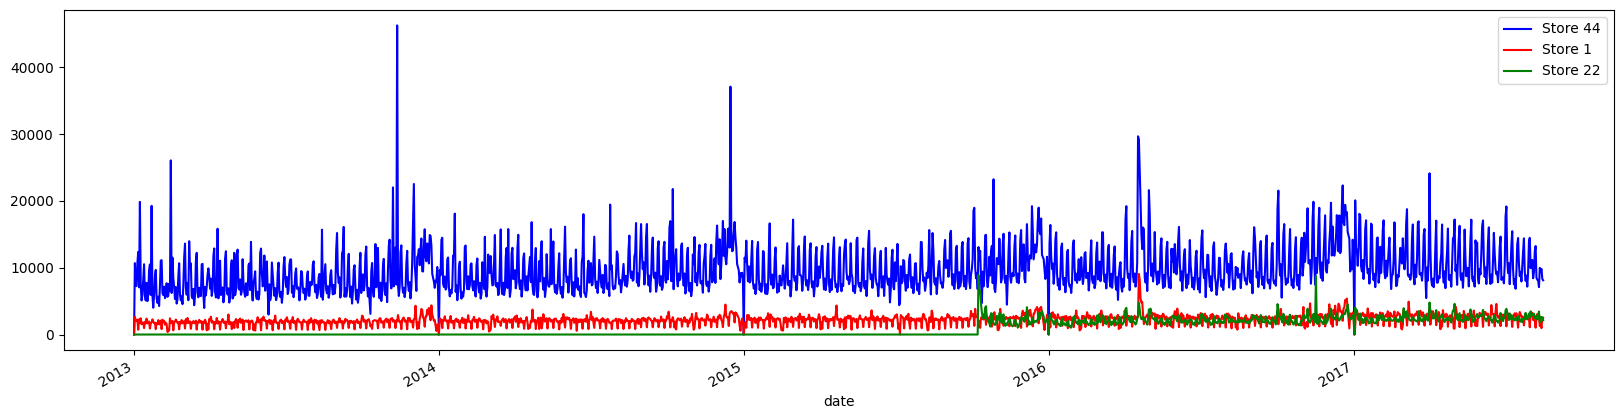

In [12]:
plt.figure(figsize = (20,5))
df_sales.loc[:, (44, 'GROCERY I')].plot(color='blue', label='Store 44')
df_sales.loc[:, (1, 'GROCERY I')].plot(color = 'red', label = 'Store 1')
df_sales.loc[:, (22, 'GROCERY I')].plot(color = 'green' , label = 'Store 22')

plt.legend()

<AxesSubplot: xlabel='date'>

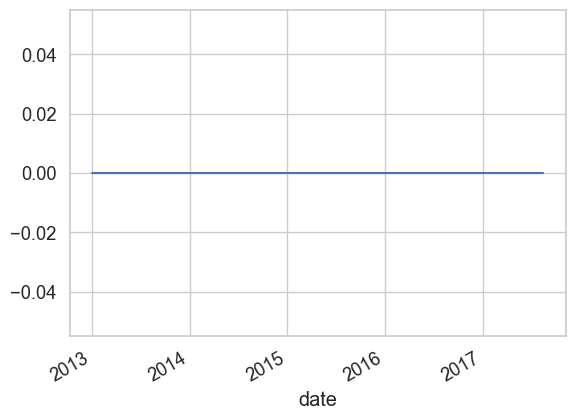

In [81]:
df_sales.loc[:, (9, 'BOOKS')].plot()

# Zero sales

<AxesSubplot: title={'center': 'Total number of categorices and stores with zero sales over time'}, xlabel='date'>

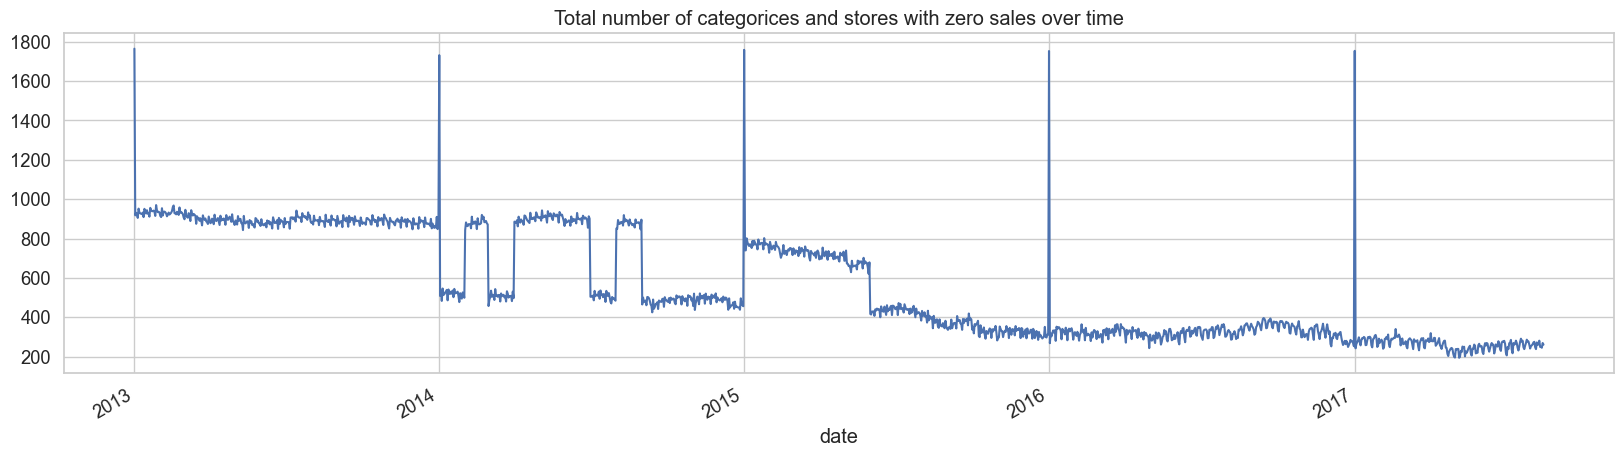

In [82]:

plt.figure(figsize = (20,5))
(df_sales.eq(0)).sum(axis=1).plot(title = "Total number of categorices and stores with zero sales over time")


In [83]:

zero_sales_counts = (df_sales ==0).groupby(level = 'family', axis =1).sum()
zero_sales_counts

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,54,54,53,53,54,53,54,53,53,53,...,54,53,53,54,54,53,53,54,54,54
2013-01-02,9,54,13,8,54,8,54,8,8,8,...,54,8,8,54,54,10,8,54,54,12
2013-01-03,12,54,21,8,54,8,54,8,8,8,...,54,8,8,54,54,8,8,54,54,11
2013-01-04,11,54,17,8,54,8,54,8,8,8,...,54,8,8,54,54,8,8,54,54,11
2013-01-05,10,54,14,8,54,8,54,8,8,8,...,54,8,8,54,54,8,8,54,54,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1,47,7,0,54,0,1,0,0,0,...,6,0,0,4,2,0,0,0,23,4
2017-08-12,1,51,4,0,54,0,0,0,0,0,...,4,0,0,2,1,0,0,0,21,6
2017-08-13,2,49,3,0,53,0,0,0,0,0,...,4,0,0,7,3,0,0,0,19,4


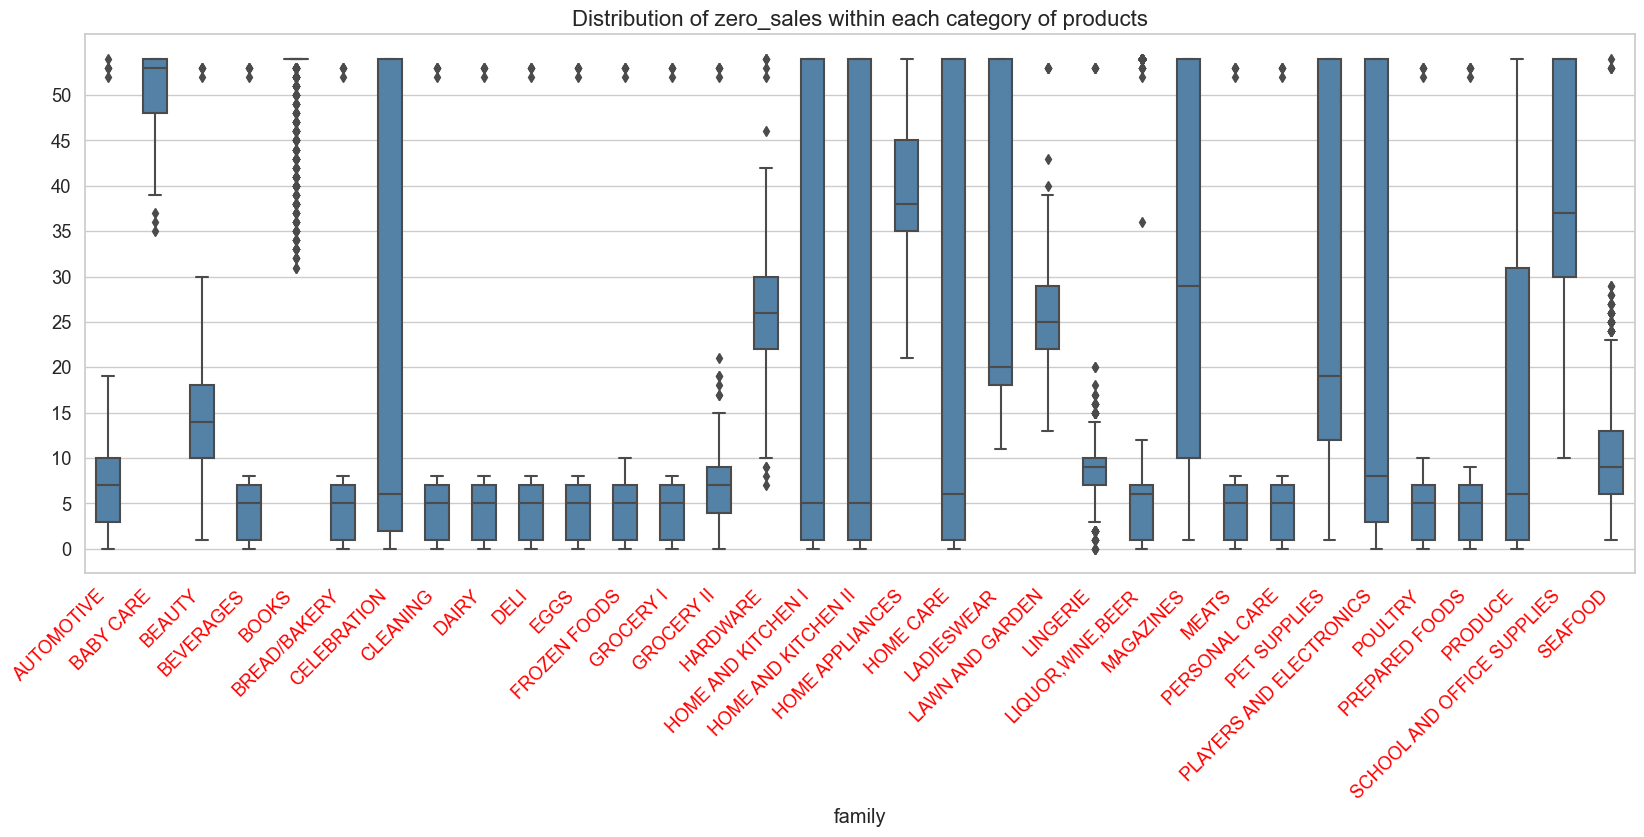

In [84]:
plt.figure(figsize = (20,7))
sns.set(style="whitegrid", font_scale=1.2) #change the font size of x and y tickes labels

ax = sns.boxplot(data= zero_sales_counts, color = "steelblue", width = .5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', color = "red")
ax.set_title("Distribution of zero_sales within each category of products", fontsize=16) #change the font size of title

plt.yticks(range(0, zero_sales_counts.max().max() + 1, 5))

#plt.tight_layout()
plt.show()

The above plot indicates that:
1. On 50% of days, we observe 2 to 7 stores with no sales (interquartile range) in the highest demand categories such as GROCERY I, CLEANING, and BEVERAGES.

2. Within the top-demand categories like GROCERY I, CLEANING, and BEVERAGES, the median is 5 stores with no sales. This means that 50% of the time, there are 5 stores without any sales activity.

3. The typical range of data, excluding potential outliers, falls between 0 and 8 stores with no sales for the highest demand categories like GROCERY I, CLEANING, and BEVERAGES.

4. In some not popular categories like HOME AND KITCHEN or CELEBRATION, on %% of days, we observe 2 to 54 stores with no sales. In these categories, on 50% of time, there are 5 stores without any sales activity.

In [86]:

zero_sales_category_counts = (df_sales ==0).groupby(level = 'store_nbr', axis =1).sum()
zero_sales_category_counts

store_nbr,1,2,3,4,5,6,7,8,9,10,...,45,46,47,48,49,50,51,52,53,54
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,33,33,33,33,33,33,33,33,33,33,...,33,33,33,33,33,33,33,33,33,33
2013-01-02,13,14,13,14,13,14,13,14,15,14,...,13,13,13,13,14,15,13,33,33,16
2013-01-03,14,13,14,14,14,13,13,13,14,15,...,13,13,14,15,15,13,13,33,33,15
2013-01-04,13,14,13,14,13,14,13,13,15,16,...,12,12,14,15,14,13,13,33,33,15
2013-01-05,13,14,13,13,13,13,13,13,13,15,...,13,12,14,14,13,13,13,33,33,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,4,4,3,3,2,4,3,2,3,5,...,2,3,2,4,3,3,4,3,4,11
2017-08-12,5,4,5,4,3,5,4,4,3,9,...,3,2,3,4,3,3,3,3,4,8
2017-08-13,5,4,3,3,3,4,4,3,3,7,...,2,3,3,3,4,3,3,3,3,8


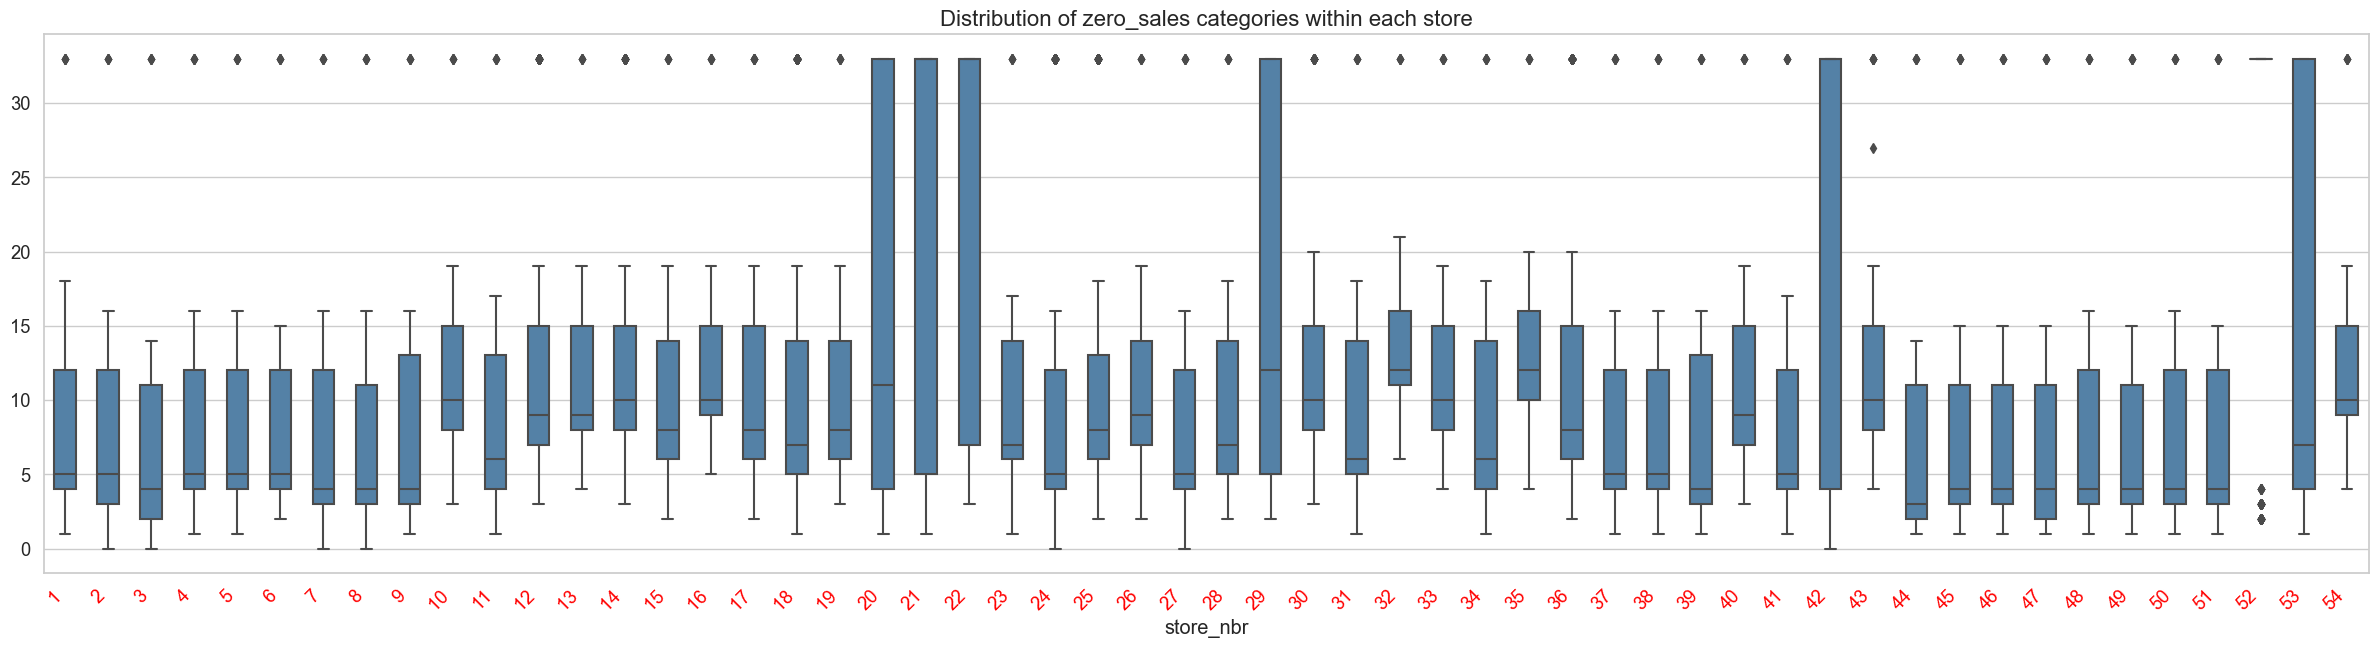

In [88]:
plt.figure(figsize = (30,7))
sns.set(style="whitegrid", font_scale=1.2) #change the font size of x and y tickes labels

ax = sns.boxplot(data= zero_sales_category_counts, color = "steelblue", width = .5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', color = "red")
ax.set_title("Distribution of zero_sales categories within each store", fontsize=16) #change the font size of title

plt.yticks(range(0, zero_sales_category_counts.max().max() + 1, 5))

#plt.tight_layout()
plt.show()

# Pivot table based on `yearmonth`, `store_nbr` and `family`

In [50]:
df1 = df.copy()
df1["yearmonth"] = pd.to_datetime(df1["year"].astype(str) + "-" + df1["month"].astype(str), format="%Y-%m")


In [54]:
df_sales_yearmonth =pd.pivot_table(df1, values ='sales', index = 'yearmonth', columns= ['store_nbr', 'family'])
df_sales_yearmonth

store_nbr          1                                                           \
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
yearmonth                                                                       
2013-01-01   2.193548       0.0  1.451613   928.290323  0.000000   276.118741   
2013-02-01   1.357143       0.0  1.642857   761.500000  0.000000   260.586965   
2013-03-01   1.903226       0.0  1.709677   856.774194  0.000000   265.538742   
2013-04-01   2.200000       0.0  1.700000   884.233333  0.000000   291.871666   
2013-05-01   2.548387       0.0  1.806452   835.903226  0.000000   263.081581   
2013-06-01   2.200000       0.0  1.500000   893.533333  0.000000   267.668667   
2013-07-01   2.258065       0.0  2.548387   826.161290  0.000000   249.791516   
2013-08-01   3.161290       0.0  2.032258   770.419355  0.000000   239.517967   
2013-09-01   2.100000       0.0  1.800000   861.233333  0.000000   278.959967   
2013-10-01   1.741935       0.0  1.741935   846.548387  0.000000   291.085000   
2013-11-01   2.100000       0.0  1.800000   867.600000  0.000000   280.911067   
2013-12-01   1.900000       0.0  1.600000   948.033333  0.000000   267.729899   
2014-01-01   2.419355       0.0  2.322581  1876.193548  0.000000   300.143420   
2014-02-01   3.035714       0.0  1.964286   898.178571  0.000000   298.149357   
2014-03-01   3.129032       0.0  2.258065  1777.032258  0.000000   285.504613   
2014-04-01   2.533333       0.0  2.133333   967.533333  0.000000   279.862133   
2014-05-01   2.032258       0.0  1.516129   911.709677  0.000000   291.162354   
2014-06-01   2.166667       0.0  1.766667   953.766667  0.000000   300.266331   
2014-07-01   3.483871       0.0  3.032258  1914.612903  0.000000   318.406355   
2014-08-01   2.193548       0.0  2.290323   941.451613  0.000000   324.014001   
2014-09-01   3.366667       0.0  2.233333  1920.133333  0.000000   361.344967   
2014-10-01   3.000000       0.0  1.709677  1929.419355  0.000000   351.245419   
2014-11-01   3.033333       0.0  2.466667  1811.233333  0.000000   327.608600   
2014-12-01   3.161290       0.0  2.935484  2016.548387  0.000000   334.022452   
2015-01-01   2.935484       0.0  1.870968   993.967742  0.000000   372.584968   
2015-02-01   2.678571       0.0  1.857143   898.107143  0.000000   341.375750   
2015-03-01   2.935484       0.0  1.580645   990.774194  0.000000   364.912033   
2015-04-01   2.766667       0.0  1.400000   987.166667  0.000000   369.834032   
2015-05-01   2.580645       0.0  2.096774  1344.387097  0.000000   358.687902   
2015-06-01   3.433333       0.0  3.533333  2068.166667  0.000000   372.911433   
2015-07-01   3.032258       0.0  2.000000  1864.161290  0.000000   381.429290   
2015-08-01   3.419355       0.0  2.322581  1856.419355  0.000000   358.274419   
2015-09-01   3.100000       0.0  2.500000  2154.700000  0.000000   387.756633   
2015-10-01   3.516129       0.0  2.870968  1930.548387  0.000000   375.033130   
2015-11-01   3.200000       0.0  2.333333  1827.000000  0.000000   362.490033   
2015-12-01   4.333333       0.0  2.800000  2107.766667  0.000000   354.508433   
2016-01-01   4.709677       0.0  1.645161  1963.419355  0.000000   354.896935   
2016-02-01   4.448276       0.0  1.965517  1966.206897  0.000000   352.005931   
2016-03-01   5.419355       0.0  2.451613  1994.806452  0.000000   382.125935   
2016-04-01   5.300000       0.0  3.366667  2313.733333  0.000000   402.917133   
2016-05-01   4.558824       0.0  2.147059  1852.970588  0.000000   395.174206   
2016-06-01   4.100000       0.0  2.766667  1887.566667  0.000000   425.601900   
2016-07-01   4.387097       0.0  2.354839  1856.709677  0.000000   393.743807   
2016-08-01   4.129032       0.0  2.709677  1903.548387  0.000000   374.359935   
2016-09-01   3.633333       0.0  3.933333  2022.800000  0.000000   405.826233   
2016-10-01   4.225806       0.0  4.548387  2123.870968  0.838710   395.592516   
2016-11-01   3.866667       0.0

<AxesSubplot: xlabel='yearmonth'>

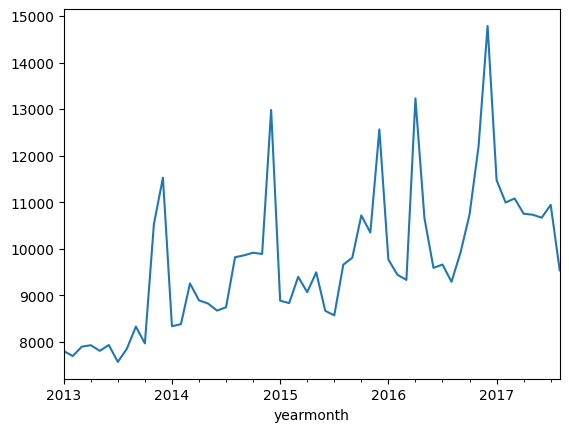

In [55]:
df_sales_yearmonth.loc[:, (44, 'GROCERY I')].plot()